In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 3.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score

In [3]:
# Load the dataset
file_path = 'dataset.txt'
# Read the entire line first
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Manually split the data into sentences and labels
sentences = []
labels = []
for line in lines:
    # Split on the last occurrence of '|'
    if '|' in line:
        parts = line.rsplit('|', 1)
        sentences.append(parts[0].strip())
        labels.append(int(parts[1].strip()))  # Assuming labels are 0 or 1

# Create a DataFrame
data = pd.DataFrame({
    'sentence': sentences,
    'label': labels
})

# Split the dataset into training, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Prepare datasets for the transformer
train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)



In [4]:
# Tokenize Dataset
tokenizer = AutoTokenizer.from_pretrained('monologg/koelectra-base-v3-discriminator')
def tokenize_data(data):
    encoded = tokenizer(data['sentence'], truncation=True)
    encoded['labels'] = data['label']
    return encoded

tokenized_train_dataset = train_dataset.map(tokenize_data, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_data, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_data, batched=True)

# Load Collator
collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average='binary'),
    precision = precision_score(p.label_ids, preds, average='binary')
    return {'accuracy': accuracy, 'f1': f1, 'precision': precision}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

Map:   0%|          | 0/4660 [00:00<?, ? examples/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Map:   0%|          | 0/583 [00:00<?, ? examples/s]

In [5]:
# Load arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    weight_decay=.03,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    evaluation_strategy='steps',
    eval_steps=300,
    save_strategy='steps',
    save_steps=300,
    logging_strategy='steps',
    logging_steps=500,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    lr_scheduler_type='cosine',
    warmup_ratio=0.1
)

# Load & Train model
model = AutoModelForSequenceClassification.from_pretrained('monologg/koelectra-base-v3-discriminator', num_labels=2)

model.config.dropout = 0.1

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=collator,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision
300,No log,0.383404,0.847079,"(0.7855421686746987,)",0.754630
600,0.437100,0.461929,0.855670,"(0.8018867924528302,)",0.755556
900,0.437100,0.429387,0.898625,"(0.8475452196382429,)",0.872340
1200,0.182900,0.498524,0.891753,"(0.8328912466843501,)",0.882022
1500,0.097600,0.491237,0.886598,"(0.8290155440414508,)",0.855615
1800,0.097600,0.567059,0.893471,"(0.8359788359788359,)",0.882682
2100,0.043500,0.600413,0.895189,"(0.8373333333333333,)",0.892045
2400,0.043500,0.615965,0.891753,"(0.8372093023255813,)",0.861702
2700,0.021700,0.621572,0.891753,"(0.8396946564885496,)",0.850515


Trainer is attempting to log a value of "(0.7855421686746987,)" of type <class 'tuple'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.8018867924528302,)" of type <class 'tuple'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.8475452196382429,)" of type <class 'tuple'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.8328912466843501,)" of type <class 'tuple'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "(0.8290155440414508,)" of type <class 'tuple'> for key "eval/f1" as a scalar. This invocation of Te

TrainOutput(global_step=2920, training_loss=0.13645761421281996, metrics={'train_runtime': 903.3544, 'train_samples_per_second': 51.586, 'train_steps_per_second': 3.232, 'total_flos': 2046843677401440.0, 'train_loss': 0.13645761421281996, 'epoch': 10.0})

In [6]:
# Evaluate the final model on the test set
test_results = trainer.evaluate(tokenized_test_dataset)

print(f"Test Accuracy: {test_results['eval_accuracy']}")
print(f"Test F1 Score: {test_results['eval_f1']}")
print(f"Test Precision: {test_results['eval_precision']}")

Trainer is attempting to log a value of "(0.8037383177570093,)" of type <class 'tuple'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Test Accuracy: 0.855917667238422
Test F1 Score: (0.8037383177570093,)
Test Precision: 0.882051282051282


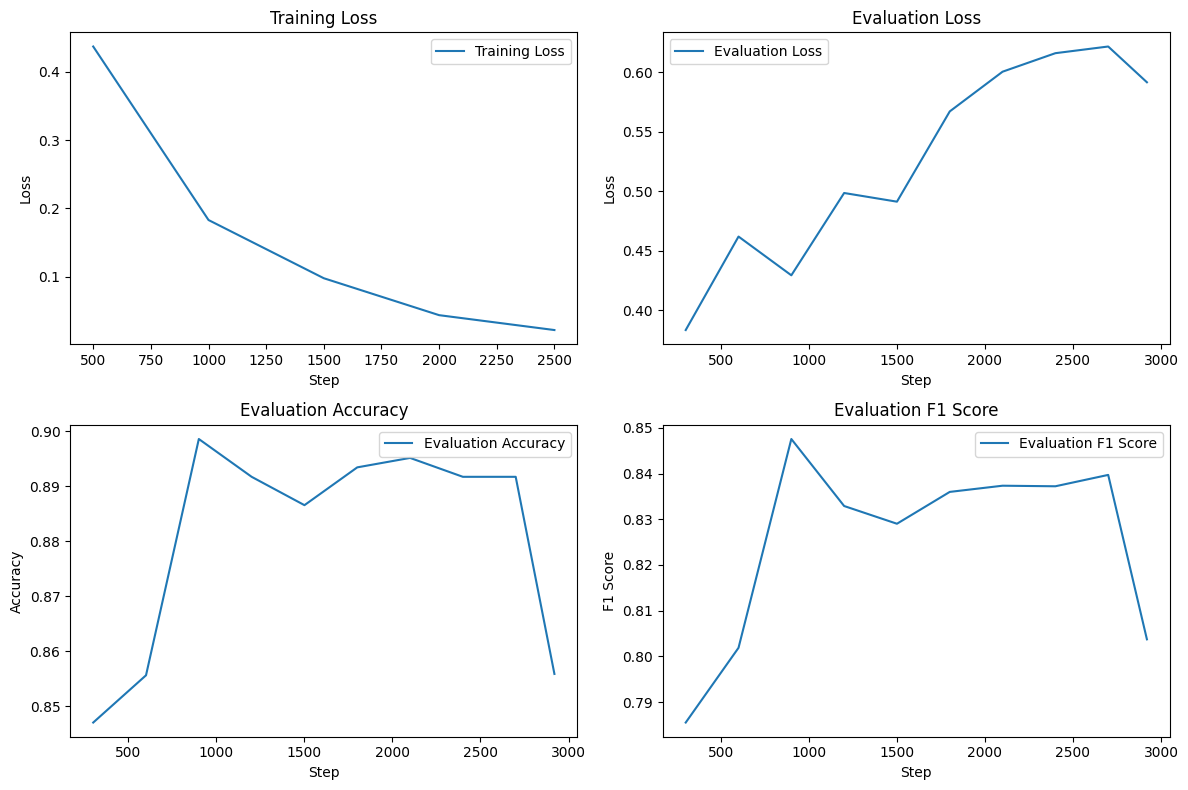

In [14]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Creating the plots
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(eval_steps, eval_f1, label='Evaluation F1 Score')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('F1 Score')
plt.title('Evaluation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

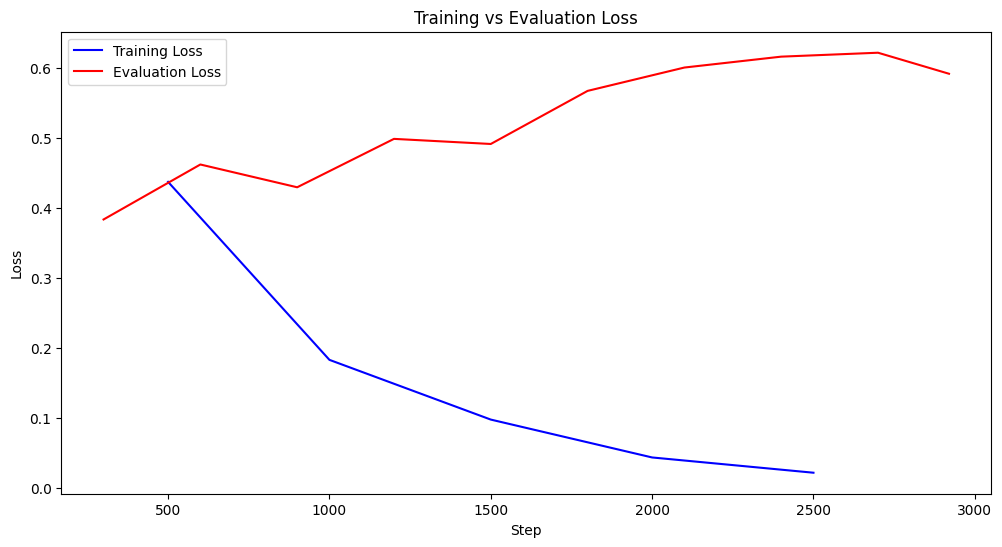

In [15]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Plotting Loss (Training and Evaluation on the same graph)
plt.figure(figsize=(12, 6))

plt.plot(train_steps, train_loss, label='Training Loss', color='blue')
plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()


In [16]:
!pip install lime

In [17]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import matplotlib.font_manager as fm
import torch

positive_indices = test_data[test_data['label'] == 1].index.tolist()

# 라벨이 1인 데이터 10개 출력
for idx in positive_indices[:10]:
    text_str = test_data.loc[idx, 'sentence']
    label = test_data.loc[idx, 'label']
    print(f"Index: {idx}, Text: {text_str}, Label: {label}")

Index: 5090, Text: 너 틀니 2주 압수, Label: 1
Index: 2412, Text: 니가 근거 가져오면 니가 이기는 게임 아니겠노 이 씨발년아 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ, Label: 1
Index: 263, Text: 몽골한테 "최근에" 250년간 지배당하고 집단강간을 당했는데 동양피가 하나도 안섞였다고 쌩어거지 떠는 초졸또라이보소 엌ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ. 니가 말하고도 너무 어거지라 좀 부끄럽지?? 엌ㅋㅋㅋㅋㅋㅋ, Label: 1
Index: 4801, Text: 티비조선이 존나게 띄워줬지 ㅋ, Label: 1
Index: 5523, Text: 김구라 와이프랑 슈 봐라 여자라고 생활력 강하고 야물딱지냐?그냥 케바케이고 뉴스 기사 남여 비율 보면 연예인, 펭수, 동물, 드라마, 쳐먹는 거에 정신 못차리는 개보지년들과 달리 정치 경제 시사 상식 있고 사회 생활 더 많이 하는 남자가 돈관리 하는게 맞음, Label: 1
Index: 3949, Text: 애미디졋네 ㄹㅇ, Label: 1
Index: 5392, Text: 현금이 많으면 노인들 죽었을때 청소업체에서 꿀꺽하는돈도 많겠네 개꿀, Label: 1
Index: 2114, Text: ㅄ 누가 고백을 카톡으로 하냐, Label: 1
Index: 896, Text: ㅋㅋㅋㅋㅋ 인생수준ㅋㅋ, Label: 1
Index: 4628, Text: 개독질, Label: 1


In [18]:
idx = 0
sample_text = test_data.iloc[idx]['sentence']

# 모델을 GPU로 이동
model = model.to('cuda')

def predict_proba(texts):
    # 텍스트를 토크나이저로 인코딩
    encoded_texts = tokenizer(texts, truncation=True, padding=True, return_tensors='pt', max_length=512)
    # 인코딩된 텍스트를 GPU로 이동
    encoded_texts = {k: v.to('cuda') for k, v in encoded_texts.items()}
    # 모델을 통해 예측
    with torch.no_grad():
        outputs = model(**encoded_texts)
    # softmax를 통해 확률을 계산
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    # 결과를 CPU로 이동하고 numpy 배열로 변환
    return predictions.to('cpu').numpy()

explainer = LimeTextExplainer(class_names=["정상", "욕설"])

# LIME을 사용하여 예측 설명 생성
# 단일 텍스트 샘플에 대해 LIME 설명을 생성하려면, 텍스트를 리스트에 담아야 합니다.
exp = explainer.explain_instance(sample_text, predict_proba, num_features=6)

# 설명 출력
print(exp.as_list())

[('2주', -0.000323221492737238), ('틀니', -0.0002144491670343183), ('너', -0.00018997740807054835), ('압수', -0.0001639414688521839)]


In [19]:
random_indices = np.random.choice(test_data.index, size=5, replace=False)

for idx in random_indices:
    sample_text = test_data.loc[idx]['sentence']

    # LIME을 사용하여 예측 설명 생성
    exp = explainer.explain_instance(sample_text, predict_proba, num_features=6)

    # 설명 출력 (텍스트로 출력)
    print(f"Explanation for index {idx}:")
    for label in exp.available_labels():
        print(f"Label {labels[label]}:")
        for feature, weight in exp.as_list(label=label):
            print(f"  {feature}: {weight}")

Explanation for index 3184:
Label 0:
  댓글달게하시네: -0.0001417480039192487
  참: 0.00011689486067700742
  훌륭한: 0.00011626835289449201
  아내분입니다: -6.809102397535457e-05
  느껴지네요: 5.9213194769742696e-05
  와: -2.9932220706162592e-05
Explanation for index 4343:
Label 0:
  애네: 0.0005908726352291155
  없을듯: -0.0005659347017080117
  엑소도: 0.0003922979514756187
  했으니: 0.00024066121384418607
  그리즈만: -0.00011342050508593431
  활동할만큼: -7.134503712073487e-05
Explanation for index 2623:
Label 0:
  올리기: -0.0006201133021775957
  댓글: -0.00028704850545405424
  이미지: -0.00010783422601717967
Explanation for index 1350:
Label 0:
  방송에서: -0.004334562299211771
  하는거임: -0.004189359567587537
  맨날: 0.004137028060592709
  그냥: -0.0013484702322249988
  얘기: -0.000955538267441954
  하는: -0.0005494569835505063
Explanation for index 3720:
Label 0:
  ㅠㅠ: -0.003828555431497535
  치킨: -0.0030552319369327053
  이런거: -0.002886047099851614
  뜯고있는뎅: 0.0018008147121749648
  올리지마: 0.0016635516603211247


In [20]:
# Save the explanation to an HTML file
exp.save_to_file('lime_explanation.html')